In [1]:
import shap
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import copy

from util.util_cnn import CNNModel, data_loaders, first_mnist_batch, test, \
                params_to_filename, params_from_filename, load_mnist_v4_models

from util.naming import *

from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain

from util.util_tutorial import heatmap

# pan kessel
from explanations_can_be_manipulated.src.nn.enums import ExplainingMethod, LRPRule
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet
from explanations_can_be_manipulated.src.nn.utils import get_expl, plot_overview, clamp, load_image, make_dir

device = 'cpu'
method = ExplainingMethod.lrp

%matplotlib inline
%load_ext autoreload
%autoreload 2

no display found. Using non-interactive Agg backend


In [2]:
# load data and pretrained models
data, target = first_mnist_batch(batch_size=200)

background = data[100:200].reshape((-1, 1, 28, 28))
background_target = target[100:200]

data = data[:100]
target = target[:100]

test_images = data[:3].reshape((-1, 1, 28, 28))

model_dict = load_mnist_v4_models()
model_d3 = model_dict[d3_tag]

In [3]:
data.shape

torch.Size([100, 784])

## Import the Explainable model of Pan

In [4]:
model = ExplainableNet(model_d3).eval().to(device)

In [5]:
gamma = 2
model.change_lrp_rules(gamma=gamma, lrp_rule_nl=LRPRule.gamma)

In [9]:
for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])

0 0.0 LRPRule.z_b
1 0.0 LRPRule.alpha_beta
2 0.0 LRPRule.alpha_beta
3 MaxPool
4 0.0 LRPRule.alpha_beta
5 0.0 LRPRule.alpha_beta
6 0.0 LRPRule.alpha_beta
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [48]:
x = data[:1].reshape((-1,1,28,28))
expl, output, classification = get_expl(model, test_images, method)

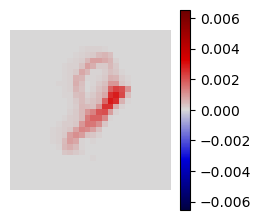

In [49]:
heatmap(expl[0].detach().reshape((28,28)), 2, 2, colorbar=True)

### Check equivalence to my implementation

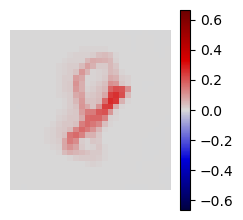

In [50]:
heatmap(rel(95)[0][0].reshape((28,28)), 2, 2, colorbar=True)

In [51]:
a = rel(95)[0][0, 0]
b = expl[0]

a.shape, b.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

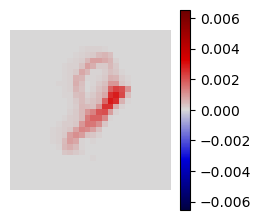

In [52]:
c = a
c[b>0] = b[b>0]
heatmap(c.detach(), colorbar=1)

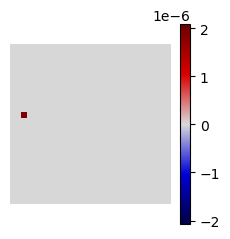

In [53]:
heatmap((a-b).detach(), colorbar=1)

In [54]:
np.abs((a-b).detach()).max()

tensor(1.9183e-06)

## SGD on Gamma

In [31]:
del ExplainableNet
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet

In [5]:
model = ExplainableNet(model_d3).eval().to(device)

for i, l in enumerate(model.layers): print(i, str(l).split('(')[0])

0 Convolutional
1 Convolutional
2 Convolutional
3 MaxPool
4 Convolutional
5 Convolutional
6 Convolutional
7 MaxPool
8 Flatten
9 Dense


In [86]:
for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])

0 tensor([nan], requires_grad=True) LRPRule.z_b
1 tensor([nan], requires_grad=True) LRPRule.gamma
2 tensor([nan], requires_grad=True) LRPRule.gamma
3 MaxPool
4 tensor([nan], requires_grad=True) LRPRule.gamma
5 tensor([nan], requires_grad=True) LRPRule.gamma
6 tensor([nan], requires_grad=True) LRPRule.gamma
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [39]:
del tqdm
from tqdm import tqdm
_, test_loader = data_loaders()

In [98]:
gamma_early = torch.Tensor([0.051]).requires_grad_(True)
gamma_late  = torch.Tensor([0.050]).requires_grad_(True)

model.change_lrp_rules(gamma=gamma_early, lrp_rule_nl=LRPRule.gamma, start_l=0, end_l=3)
model.change_lrp_rules(gamma=gamma_late , lrp_rule_nl=LRPRule.gamma, start_l=4, end_l=8)

for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])
    
gammas = []
losses = []
optimizer = torch.optim.Adam([gamma_early, gamma_late], lr=0.0002)

0 tensor([0.0500], requires_grad=True) LRPRule.z_b
1 tensor([0.0510], requires_grad=True) LRPRule.gamma
2 tensor([0.0510], requires_grad=True) LRPRule.gamma
3 MaxPool
4 tensor([0.0500], requires_grad=True) LRPRule.gamma
5 tensor([0.0500], requires_grad=True) LRPRule.gamma
6 tensor([0.0500], requires_grad=True) LRPRule.gamma
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [99]:
n_epochs = 1

for i in tqdm(range(n_epochs)):
    for x, target in tqdm(test_loader):
        x = x.reshape((-1,1,28,28)).data

        optimizer.zero_grad()

        # calculate entropy loss
        expl, output, classification = get_expl(model, x, method)
        # construct 'probability distribution'
        print(expl.view(-1)[:10])
        dist = expl.abs()
        dist /= dist.sum((1,2), keepdim=True)
        ent = torch.special.entr(dist)
        print(ent)
        loss = ent.sum()

        # update adversarial example
        loss.backward()
        print(dist.grad)
        print(expl.grad)
        break
        optimizer.step()
        
        a, b = float(gamma_early.detach()), float(gamma_late.detach())
        
        gammas.append([a, b])
        losses.append(loss.data)
        
        print('loss: ', float(loss.data))
        print('early:', a, float(model.layers[1].gamma.data), float(model.layers[1].gamma.grad))
        print('late: ', b, float(model.layers[4].gamma.data), float(model.layers[4].gamma.grad))

  0%|         | 0/84 [00:00<?, ?it/s]The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646991213/work/build/aten/src/ATen/core/TensorBody.h:485.)
The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more i

tensor([3.3218e-08, 2.1714e-08, 9.5738e-09, 2.8640e-08, 4.9906e-08, 1.0218e-07,
        1.0411e-07, 3.8581e-08, 3.8643e-07, 4.6096e-07],
       grad_fn=<SliceBackward0>)
tensor([[[8.9445e-05, 6.0579e-05, 2.8500e-05,  ..., 4.7229e-04,
          3.3640e-04, 5.4599e-05],
         [1.3719e-04, 8.3737e-05, 2.5318e-05,  ..., 1.2000e-04,
          2.0623e-04, 3.1722e-04],
         [8.4639e-05, 5.2083e-05, 1.5448e-06,  ..., 9.0024e-04,
          7.2769e-04, 8.6365e-05],
         ...,
         [4.9272e-05, 6.9239e-05, 2.4571e-05,  ..., 1.0905e-04,
          8.8627e-05, 4.9491e-05],
         [7.9440e-06, 1.2098e-05, 3.9469e-05,  ..., 1.0121e-04,
          7.4417e-05, 5.7517e-05],
         [5.0961e-06, 2.6417e-05, 6.0644e-05,  ..., 1.3830e-04,
          1.4775e-04, 9.4619e-05]],

        [[1.2975e-04, 1.7966e-04, 2.1179e-04,  ..., 1.7498e-04,
          2.3595e-04, 1.5504e-04],
         [2.2203e-04, 3.0550e-04, 3.3618e-04,  ..., 5.9768e-04,
          4.4590e-04, 1.3991e-04],
         [1.2451e-04, 

In [58]:
a, b = float(gamma_early.detach().numpy()), float(gamma_late.detach().numpy())
a, b

(1.1624140739440918, 0.9723686575889587)

In [92]:
gammas

[[nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan]]

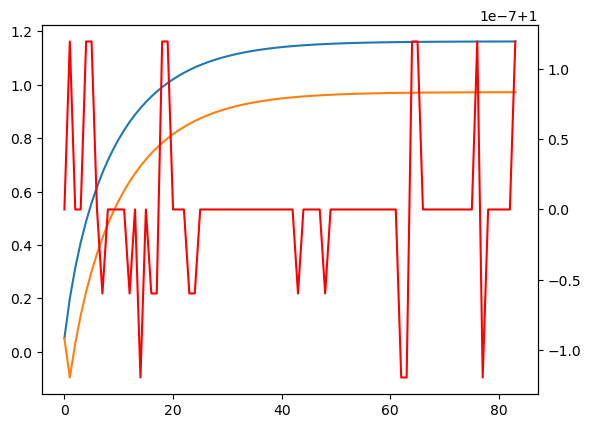

In [60]:
fig, ax = plt.subplots()
ax.plot(gammas)
ax.twinx().plot(losses, c='r')

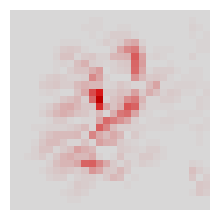

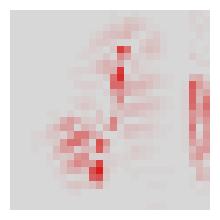

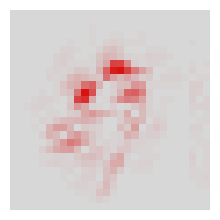

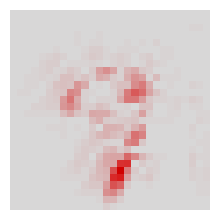

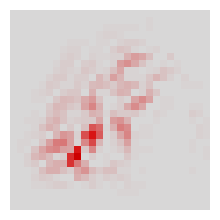

In [101]:
for ex in expl[:5]:
    heatmap(ex.detach())
    plt.show()

## Shap vs LRP

In [ ]:
e = shap.DeepExplainer(model_d3, background)
shap_values = e.shap_values(test_images)

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

## LRP computation (my implementation)

In [14]:
relevancies_per_mode = {}

In [15]:
modes = {
    0: "LRP-0.", 
    1: "Gamma. l<4 gamma=0.125",
    2: "Gamma. l<4 gamma=0.25",
    3: "Gamma. l<4 gamma=0.5",
    
    92: "Gamma. l<1000 gamma=0.25",
    95: "Gamma. l<1000 gamma=2.",
    99: "Gamma. l<1000 gamma=inf",
   
    # 99: "info."
}

In [16]:
def rel(index):
    if type(index) in [int, float]:
        index = modes[index]
    assert type(index) is str
    return copy.deepcopy(relevancies_per_mode[index])

In [17]:
A, layers = layerwise_forward_pass(model_d3, data)
L = len(layers)

A_shapes = [a.shape[1:] for a in A]

In [18]:
for mode in tqdm(modes.values()):
    if mode in relevancies_per_mode: continue
    rels = compute_relevancies(mode=mode, layers=layers, A=A, output_rels='correct class', target=target)
    if mode!="info": relevancies_per_mode[mode] = rels

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
lrp_numpy = rel(92)[0][:3].numpy()
lrp_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in lrp_numpy[None]]

print(np.array(lrp_numpy).shape)

(1, 3, 28, 28, 1)


In [22]:
lrp_numpy[0].shape

(3, 28, 28, 1)

In [27]:
np.array(shap_numpy).shape, np.array(lrp_numpy).shape, test_numpy.shape

NameError: name 'shap_numpy' is not defined

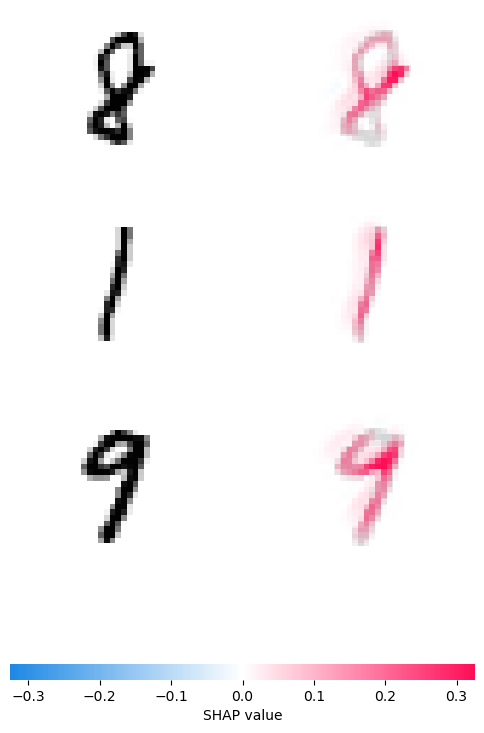

In [30]:
# plot the feature attributions
shap.image_plot(lrp_numpy, -test_numpy)